In [1]:
import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.pipeline import make_pipeline
import os

# skimage
import skimage
import skimage.color
import skimage.transform
import skimage.feature
import skimage.io

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class rgb2gray_transform(BaseEstimator,TransformerMixin):
    import skimage.color
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        return np.array([skimage.color.rgb2gray(x) for x in X])
    
    
class hogtransformer(BaseEstimator,TransformerMixin):
    import skimage.feature
    def __init__(self,orientations=9,pixels_per_cell=(8, 8),cells_per_block=(3, 3),):
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        
        
    def fit(self,X,y=None):
        return self
    
    def transform(self,X,y=None):
        def local_hog(img):
            hog_features= skimage.feature.hog(img,orientations=self.orientations,
                                pixels_per_cell=self.pixels_per_cell,
                                cells_per_block=self.cells_per_block)
            
            return hog_features
        
        hfeatures = np.array([local_hog(x) for x in X])
        return hfeatures

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# pipeline model
image = skimage.io.imread('eagle.jpg')
# transform image into 80 x 80
image_resize = skimage.transform.resize(image,(80,80))
image_scale = 255*image_resize
image_transform = image_scale.astype(np.uint8)
# rgb to gray
gray = skimage.color.rgb2gray(image_transform)
# hog feature
feature_vector = skimage.feature.hog(gray,
                              orientations=10,
                              pixels_per_cell=(8,8),cells_per_block=(2,2))

In [25]:
feature_vector

array([0.19801825, 0.14617992, 0.12000975, ..., 0.0459591 , 0.04528046,
       0.00672236])

In [26]:
import pickle
# load the model
model = pickle.load(open('dsa_image_classification_sgd.pickle','rb'))
scaler = pickle.load(open('dsa_scaler.pickle','rb'))

In [27]:
feature_vector.shape

(3240,)

In [28]:
scalex = scaler.transform(feature_vector.reshape(1,-1))
result = model.predict(scalex)

In [29]:
result

array(['eagle'], dtype='<U8')

In [30]:
# cal the probabilty 
decision_value = model.decision_function(scalex)

In [31]:
decision_value

array([[-151.451246  , -196.17529227, -128.27624345, -201.90384607,
        -260.94980395, -209.30173571,  -41.07655789,   52.24284814,
        -223.17132323, -162.27167075, -311.18099825,  -89.84329435,
        -247.25466103, -173.61231722, -105.97956015,  -97.29104892,
        -144.69841515, -153.07220666, -150.52299135, -322.45981149]])

In [32]:
labels = model.classes_

In [33]:
decision_value = decision_value.flatten()

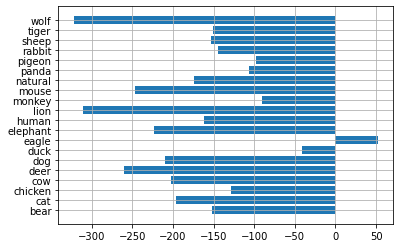

In [34]:
plt.barh(labels,decision_value)
plt.grid()

In [35]:
# cal. z score
z = scipy.stats.zscore(decision_value)
prob_value = scipy.special.softmax(z)
prob_value

array([0.0334545 , 0.01990674, 0.04378044, 0.01862612, 0.00938579,
       0.01709344, 0.12046332, 0.35586002, 0.01455167, 0.02950589,
       0.00523908, 0.06839449, 0.01100293, 0.02586666, 0.05671239,
       0.06273023, 0.03618226, 0.03283094, 0.03381691, 0.00459619])

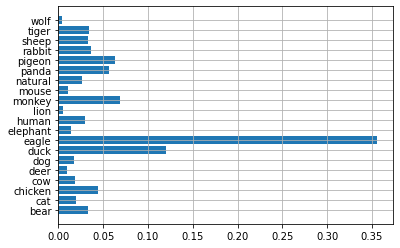

In [36]:
plt.barh(labels,prob_value)
plt.grid()

In [37]:
# top five probabilty values
top_5_prob_ind = prob_value.argsort()[::-1][:5]

In [38]:
top_5_prob_ind

array([ 7,  6, 11, 15, 14])

In [39]:
top_labels = labels[top_5_prob_ind]
top_prob = prob_value[top_5_prob_ind]

In [40]:
top_prob,top_labels

(array([0.35586002, 0.12046332, 0.06839449, 0.06273023, 0.05671239]),
 array(['eagle', 'duck', 'monkey', 'pigeon', 'panda'], dtype='<U8'))

In [41]:
top_dict = dict()
for key,val in zip(top_labels,top_prob):
    top_dict.update({key:np.round(val,3)})

In [42]:
top_dict

{'eagle': 0.356,
 'duck': 0.12,
 'monkey': 0.068,
 'pigeon': 0.063,
 'panda': 0.057}

In [43]:
def pipeline_model(path,scaler_transform,model_sgd):
    # pipeline model
    image = skimage.io.imread(path)
    # transform image into 80 x 80
    image_resize = skimage.transform.resize(image,(80,80))
    image_scale = 255*image_resize
    image_transform = image_scale.astype(np.uint8)
    # rgb to gray
    gray = skimage.color.rgb2gray(image_transform)
    # hog feature
    feature_vector = skimage.feature.hog(gray,
                                  orientations=10,
                                  pixels_per_cell=(8,8),cells_per_block=(2,2))
    # scaling
    
    scalex = scaler_transform.transform(feature_vector.reshape(1,-1))
    result = model_sgd.predict(scalex)
    # decision function # confidence
    decision_value = model_sgd.decision_function(scalex).flatten()
    labels = model_sgd.classes_
    # probability
    z = scipy.stats.zscore(decision_value)
    prob_value = scipy.special.softmax(z)
    
    # top 5
    top_5_prob_ind = prob_value.argsort()[::-1][:5]
    top_labels = labels[top_5_prob_ind]
    top_prob = prob_value[top_5_prob_ind]
    # put in dictornary
    top_dict = dict()
    for key,val in zip(top_labels,top_prob):
        top_dict.update({key:np.round(val,3)})
    
    return top_dict

In [44]:
res = pipeline_model('eagle.jpg',scaler,model)
res

{'eagle': 0.356,
 'duck': 0.12,
 'monkey': 0.068,
 'pigeon': 0.063,
 'panda': 0.057}